In [1]:
from PIL import Image#帮我们读取图像
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torchvision
from torchvision import transforms

In [2]:
class resnet_base(nn.Module):
    def __init__(self,in_channel,out_channel):
        super().__init__()
        self.conv1=nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,bias=False)#使输入图像和输出图像大小相同，这样才能相加
        self.bn1=nn.BatchNorm2d(out_channel,)#批标准化后这一批的数据就失去了原有的量纲了，就不需要卷积中的b了，就可以不适用b来加速计算
        
        self.conv2=nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1,bias=False)#使输入图像和输出图像大小相同，这样才能相加
        self.bn2=nn.BatchNorm2d(out_channel,)#批标准化后这一批的数据就失去了原有的量纲了，就不需要卷积中的b了，就可以不适用b来加速计算
    def forward(self,x):
        res=x   #保存输入（残差）以便之后相加
        out=self.conv1(x)
        out=F.relu(self.bn1(out),inplace=False)#这样就直接在原始数据上进行改变，就不保存原始数据了（原本是将值赋到relu中再将结果赋回去，现在直接就地改变），会加快运算速度
        out=self.conv1(x)
        out=F.relu(self.bn1(out),inplace=False)
        out+=res    #输出与输入相加
        return (F.relu(out))

In [3]:
model=torchvision.models.resnet101

In [4]:
model??

Signature: model(pretrained=False, **kwargs)
Source:   
def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model
File:      c:\programdata\anaconda3\envs\text\lib\site-packages\torchvision\models\resnet.py
Type:      function


# DenseNet

In [5]:
images_path=glob.glob(r'D:/数据集/birds/*/*.jpg')

In [6]:
images_path[100].split('\\')[1].split('.')[1]#使用这种方法将类别名称提取出来

'Laysan_Albatross'

In [7]:
image_name=[p.split("\\")[1].split(".")[1] for p in images_path ]

In [8]:
unique_labels=np.unique(image_name)#获取所有不相同的类

In [9]:
len(unique_labels)

200

In [10]:
label_to_index=dict((v,k) for k,v in enumerate(unique_labels))

In [11]:
index_to_label=dict((c,d) for d,c in label_to_index.items())

In [12]:
all_labels=[label_to_index.get(name) for name in image_name]

In [13]:
#np.random.seed(2021)#设立相同种子产生的随机数相同
index=np.random.permutation(len(all_labels))

In [14]:
images_path=np.array(images_path)[index]
all_labels=np.array(all_labels)[index]

In [122]:
i=int(len(all_labels)*0.8)

In [123]:
train_img=images_path[:i]
train_label=all_labels[:i]

test_img=images_path[i:]
test_label=all_labels[i:]

In [125]:
test_img

array(['D:/数据集/birds\\037.Acadian_Flycatcher\\Acadian_Flycatcher_0031_795582.jpg',
       'D:/数据集/birds\\120.Fox_Sparrow\\Fox_Sparrow_0035_114866.jpg',
       'D:/数据集/birds\\051.Horned_Grebe\\Horned_Grebe_0071_35078.jpg', ...,
       'D:/数据集/birds\\018.Spotted_Catbird\\Spotted_Catbird_0009_796795.jpg',
       'D:/数据集/birds\\148.Green_tailed_Towhee\\Green_Tailed_Towhee_0092_797397.jpg',
       'D:/数据集/birds\\195.Carolina_Wren\\Carolina_Wren_0086_186431.jpg'],
      dtype='<U94')

In [126]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [127]:
class birds(data.Dataset):
    def __init__(self,images_path,label):
        super().__init__()
        self.labels=label
        self.imgs=images_path
    def __getitem__(self, index) :
       img=self.imgs[index]
       labels=self.labels[index]
       pil_img=Image.open(img) 
       #若图片是灰度图片，就需要人为的给他添加维度
       #彩色图片的shape有3个，为H,W,C。灰度图片只有H,W,shape是2
       np_img=np.asarray(pil_img,dtype=np.uint8)#先转换成numpy格式的方便使用
       if len(np_img.shape)==2:
           img_data=np.repeat(np_img[:,:,np.newaxis],3,axis=2)#添加一个值为1的新的维度，将最后一个维度重复三次
           pil_img=Image.fromarray(img_data)#再转换成pil_image形式
       img_tensor=transform(pil_img)
       return img_tensor,labels
    def __len__(self):
        return len(self.imgs)


In [128]:
train_ds=birds(train_img,train_label)
test_ds=birds(test_img,test_label)
train_dl=data.DataLoader(train_ds,batch_size=8)#我们只是提取特征，所以没有必要做乱序
test_dl=data.DataLoader(test_ds,batch_size=8)

In [129]:
img_batch,label_batch=next(iter(train_dl))

In [130]:
img_batch.shape

torch.Size([8, 3, 224, 224])

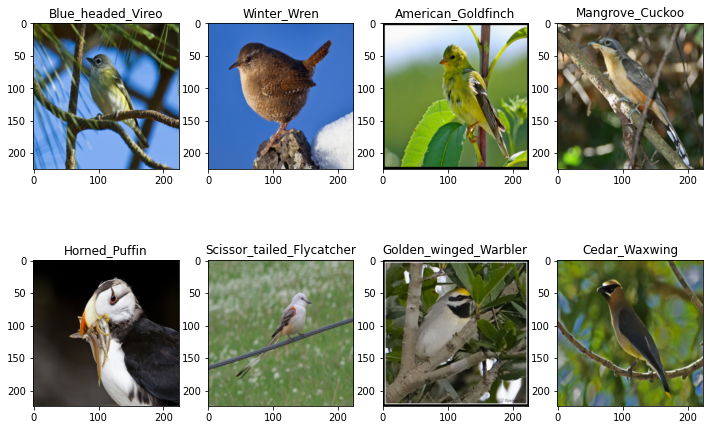

In [131]:
plt.figure(figsize=(12,8))
for i,(img,name)in enumerate(zip(img_batch,label_batch)):
    plt.subplot(2,4,i+1)
    plt.imshow(img.permute(1,2,0).numpy())
    plt.title(index_to_label[name.item()])#或是index_to_label.get(name.item())

In [132]:
model=torchvision.models.densenet121(pretrained=True).features#这样获得模型的卷积基部分

In [133]:
model=model.cuda()

In [134]:
for p in model.parameters():
    p.requires_grad=False#使卷积基部分不可训练

In [135]:
train_features=[]
train_fea_labels=[]#创建一个用来储存图像特征的空列表
for im ,la in train_dl:
    out=model(im.cuda())   #这样返回值就是特征,但此时的输出是4维的（batch_size,c,w,h）
                           #模型放到显卡上后，图像数据也要放到显卡上
    out=out.view(out.size(0),-1)#所以要将输出扁平化，第一个维度是batch_size，按批数进行展开
    train_features.extend(out.cpu().data)#将这些扁平化的特征放到列表中，因为可能要在cpu上进行处理所以给cpu，我们只需要它的值，不需要梯度之类的信息，所以.data
    train_fea_labels.extend(la)#标签不做处理

test_features=[]
test_fea_labels=[]
for im ,la in test_dl:
    out=model(im.cuda())   
    out=out.view(out.size(0),-1)
    test_features.extend(out.cpu().data)
    test_fea_labels.extend(la)

In [138]:
len(test_features)

2358

In [139]:
train_features[0].shape#这就是一张图片的特征，有50176个数

torch.Size([50176])

In [140]:
class Feature_ds(nn.Module):
    def __init__(self,fea_list,lab_list):
        super().__init__()
        self.fea_list=fea_list
        self.label_list=lab_list
    def __getitem__(self,index):
        return (self.fea_list[index],self.label_list[index])
    def __len__(self):
        return len(self.label_list)

In [141]:
train_fea_ds=Feature_ds(train_features,train_fea_labels)
test_fea_ds=Feature_ds(test_features,test_fea_labels)
train_dl=data.DataLoader(train_fea_ds,batch_size=8,shuffle=True)
test_dl=data.DataLoader(test_fea_ds,batch_size=8)

In [142]:
test_features

[tensor([-2.7500e-04,  9.2198e-06, -3.8620e-04,  ...,  2.2218e-02,
         -4.6960e-02,  1.6204e-01]),
 tensor([-4.6097e-04,  1.1282e-04,  1.7394e-04,  ...,  2.0272e+00,
          2.1529e+00,  1.8714e+00]),
 tensor([ 6.2133e-04,  1.8036e-04, -6.6878e-05,  ...,  4.2304e-02,
         -2.1999e-01, -1.5603e-01]),
 tensor([ 2.9500e-04, -5.8504e-04,  3.4825e-04,  ...,  1.1489e+00,
          3.4518e+00,  2.6807e+00]),
 tensor([-6.8863e-04, -4.1599e-04,  8.4803e-04,  ...,  9.9722e-01,
          1.3491e+00,  3.5120e-01]),
 tensor([-2.4226e-04,  1.0555e-04,  3.1668e-04,  ...,  3.2452e-02,
         -1.0669e+00, -6.1082e-01]),
 tensor([-3.6664e-04,  5.6263e-05, -4.4225e-04,  ...,  8.3998e-02,
         -8.5377e-01, -8.0121e-01]),
 tensor([ 3.4119e-04,  4.4860e-04,  7.9816e-04,  ...,  4.7434e-01,
         -1.1326e-01, -2.0868e-01]),
 tensor([-2.6316e-04, -1.7093e-06,  1.4799e-04,  ..., -1.0264e-01,
         -3.4281e-01, -8.5296e-01]),
 tensor([ 3.5067e-04, -4.8949e-05, -3.4786e-04,  ..., -7.7399e-0

In [143]:
in_feature_size=train_features[0].shape[0]#torch.size里没有item方法，所以直接.shape[0]将数值提取出来就行
in_feature_size

50176

In [144]:
class FCmodel(nn.Module):
    def __init__(self,in_size,out_size):
        super().__init__()
        self.lin1=torch.nn.Linear(in_size,out_size)
    def forward(self,x):
        return self.lin1(x)

In [145]:
net=FCmodel(in_feature_size,200)#200分类

In [146]:
net

FCmodel(
  (lin1): Linear(in_features=50176, out_features=200, bias=True)
)

In [147]:
net.cuda()
loss_fn=torch.nn.CrossEntropyLoss()
optim=torch.optim.Adam(net.parameters(),lr=0.00001)#因为只是训练特征，所以训练速度小一点

In [151]:
def fit(epoch,model,trainloader,testloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0                              #总样本的个数
    running_loss=0
    model.train()      #使用dropout层和BN层时一定要加这一句表明模型正处于训练状态下  
    for x,y in trainloader:  
        y=torch.tensor(y,dtype=torch.long)#将标签转化为torch.long 类型
        x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
        y_pred=model(x)
        loss=loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():                  #每一个y值进行一次计算，这是对训练数据
            y_pred=torch.argmax(y_pred,dim=1)
            correct+=(y_pred==y).sum().item()  #每一次正确的个数加到correct里
            total+=y.size(0)                   #每一批样本的个数
            running_loss+=loss.item()          #每一批样本的loss
        
    #exp_lr_scheduler.step() #如果定义了学习速率衰减可以打开这个屏蔽
    
    epoch_acc=correct/total                #正确率为正确个数除以样本个数
    epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
    
    
    test_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
    test_total=0                              
    test_running_loss=0
    model.eval()      #告诉模型现在是预测模式，dropout层不需要发挥作用  
    with torch.no_grad():                  
            for x,y in testloader: 
                
                y=torch.tensor(y,dtype=torch.long)#将标签转化为torch.long 类型
                x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
                y_pred=model(x)
                loss=loss_fn(y_pred,y)
                
                y_pred=torch.argmax(y_pred,dim=1)
                test_correct+=(y_pred==y).sum().item() 
                test_total+=y.size(0) 
                
                test_running_loss+=loss.item()
    
    epoch_test_acc=test_correct/test_total                
    epoch_test_loss=running_loss/len(testloader.dataset)  
    
    print('epoch: ',epoch,'loss: ',round(epoch_loss,3),
                            'accuracy: ',round(epoch_acc,3),
                            'text_loss: ',round(epoch_test_loss,3),
                            'text_accuracy: ',round(epoch_test_acc,3))
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc  
                                                #这样就会将每个epoch上的这些平均正确率和平均损失返回

In [152]:
epochs=50

In [153]:
train_loss=[] #创建几个空的列表来存放数据,方便绘图，看看模型怎么样
train_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc =fit(epoch,net,train_dl,test_dl)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

C:\Users\tao'ge\AppData\Local\Temp/ipykernel_644/1103594692.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y,dtype=torch.long)#将标签转化为torch.long 类型
C:\Users\tao'ge\AppData\Local\Temp/ipykernel_644/1103594692.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y,dtype=torch.long)#将标签转化为torch.long 类型


epoch:  0 loss:  0.013 accuracy:  0.999 text_loss:  0.053 text_accuracy:  0.57
epoch:  1 loss:  0.006 accuracy:  1.0 text_loss:  0.024 text_accuracy:  0.575
epoch:  2 loss:  0.003 accuracy:  1.0 text_loss:  0.013 text_accuracy:  0.585
epoch:  3 loss:  0.002 accuracy:  1.0 text_loss:  0.008 text_accuracy:  0.587
epoch:  4 loss:  0.001 accuracy:  1.0 text_loss:  0.004 text_accuracy:  0.596
epoch:  5 loss:  0.001 accuracy:  1.0 text_loss:  0.003 text_accuracy:  0.595
epoch:  6 loss:  0.0 accuracy:  1.0 text_loss:  0.002 text_accuracy:  0.598
epoch:  7 loss:  0.0 accuracy:  1.0 text_loss:  0.001 text_accuracy:  0.597
epoch:  8 loss:  0.0 accuracy:  1.0 text_loss:  0.001 text_accuracy:  0.601
epoch:  9 loss:  0.0 accuracy:  1.0 text_loss:  0.0 text_accuracy:  0.602
epoch:  10 loss:  0.0 accuracy:  1.0 text_loss:  0.0 text_accuracy:  0.607
epoch:  11 loss:  0.0 accuracy:  1.0 text_loss:  0.0 text_accuracy:  0.607
epoch:  12 loss:  0.0 accuracy:  1.0 text_loss:  0.0 text_accuracy:  0.609
epoc

# inception

In [154]:
class base_con(nn.Module):
    def __init__(self,in_channel,out_channel,**kwargs):#有很多卷积核参数我们不写了用**kwargs表示
        super().__init__()
        self.conv=nn.Conv2d(in_channel,out_channel,bias=False,**kwargs)#因为后面要使用BN层，所以偏置不起作用，所以不如不使用
        self.bn=nn.BatchNorm2d(out_channel)
    def forward(self,x):
        x=self.conv(x)
        x=self.bn(x)
        return F.relu(x,inplace=True)#只要不适用残差就可以直接在原数据上进行更改

In [155]:
class incepetion_block(nn.Module):
    def __init__(self,in_channel,pool_features):#pool_features是在最后的1x1卷积这里要输出多少个特征
        super().__init__()
        self.b_1x1=base_con(in_channel,64,kernel_size=1)#因为之前输入的参数有**kwargs，所以我们可以直接定义这个函数的其他参数
                                                        #这是模型最左边的1x1的卷积核
        self.b_3x3_1=base_con(in_channel,64,kernel_size=1)
        self.b_3x3_2=base_con(64,96,kernel_size=3,padding=1)#因为卷积核大小为3，所以填充1使得图像大小不变
                                                            #这是左边第二条通道，先1*1再3*3
        self.b_5x5_1=base_con(in_channel,48,kernel_size=1)
        self.b_5x5_2=base_con(48,64,kernel_size=5,padding=2)#这是第三个模块

        self.b_pool=base_con(in_channel,pool_features,kernel_size=1)#因为池化不需要初始化，所以只初始化一个1x1的卷积就行
    def forward(self,x):
        b_1x1_out=self.b_1x1(x)

        b_3x3=self.b_3x3_1(x)
        b_3x3_out=self.b_3x3_2(b_3x3)

        b_5x5=self.b_5x5_1(x)
        b_5x5_out=self.b_5x5_2(b_5x5)

        b_pool_out=F.max_pool2d(x,kernel_size=3,stride=1,padding=1) #也是进行1的填充使得图像大小不变
        b_pool_out=self.b_pool(b_pool_out)

        outputs=[b_1x1_out,b_3x3_out,b_5x5_out,b_pool_out]
        return torch.cat(outputs,dim=1)#沿着第二个维度进行合并，第一个维度时batch_size,第二个是channel
        


In [156]:
model=incepetion_block(32,64)

In [157]:
model

incepetion_block(
  (b_1x1): base_con(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b_3x3_1): base_con(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b_3x3_2): base_con(
    (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b_5x5_1): base_con(
    (conv): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (b_5x5_2): base_con(
    (conv): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [158]:
model=torchvision.models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to C:\Users\tao'ge/.cache\torch\hub\checkpoints\inception_v3_google-1a9a5a14.pth
  2%|▏         | 1.57M/104M [00:02<03:11, 558kB/s]


KeyboardInterrupt: 